In [18]:
# Basic python modules
import numpy as np
import matplotlib.pyplot as plt
import os

# OQ modules
from openquake.hazardlib.gsim import get_available_gsims
#from openquake.hazardlib.gsim.base import RuptureContext, SitesContext, DistancesContext
from openquake.hazardlib.contexts import RuptureContext, SitesContext, DistancesContext
from openquake.hazardlib.imt import SA
from openquake.hazardlib import const

In [10]:
gmpe_list = get_available_gsims()
gmpe_list

{'AbrahamsonEtAl2014': openquake.hazardlib.gsim.abrahamson_2014.AbrahamsonEtAl2014,
 'AbrahamsonEtAl2014NSHMPLower': openquake.hazardlib.gsim.nshmp_2014.NSHMP2014,
 'AbrahamsonEtAl2014NSHMPMean': openquake.hazardlib.gsim.nshmp_2014.NSHMP2014,
 'AbrahamsonEtAl2014NSHMPUpper': openquake.hazardlib.gsim.nshmp_2014.NSHMP2014,
 'AbrahamsonEtAl2014RegCHN': openquake.hazardlib.gsim.abrahamson_2014.AbrahamsonEtAl2014,
 'AbrahamsonEtAl2014RegJPN': openquake.hazardlib.gsim.abrahamson_2014.AbrahamsonEtAl2014,
 'AbrahamsonEtAl2014RegTWN': openquake.hazardlib.gsim.abrahamson_2014.AbrahamsonEtAl2014,
 'AbrahamsonEtAl2015SInter': openquake.hazardlib.gsim.abrahamson_2015.AbrahamsonEtAl2015SInter,
 'AbrahamsonEtAl2015SInterHigh': openquake.hazardlib.gsim.abrahamson_2015.AbrahamsonEtAl2015SInterHigh,
 'AbrahamsonEtAl2015SInterLow': openquake.hazardlib.gsim.abrahamson_2015.AbrahamsonEtAl2015SInterLow,
 'AbrahamsonEtAl2015SInter_scaled': openquake.hazardlib.gsim.abrahamson_2015.AbrahamsonEtAl2015SInter_sca

- integer: 1,2,3,15 (int) -> nros enteros
- float: 1.2323, pi, -123.999 -> nros reales (decimales)
- complex: nros complejos

In [20]:
# Rupture Context

rctx = RuptureContext()
rctx.mag = np.array([9.0])

# Sites Context

sctx = SitesContext()
sctx.vs30 = np.array([760.0])
sctx.backarc = False
sctx.sids = np.array([1])

# Distance Context

dctx = DistancesContext()
dctx.rrup = np.array([120.0])

In [24]:
periods = np.logspace(-2, 1, 100) # 0.01 a 10, 100 numeros

imts = [SA(period) for period in periods]

stddev_types = [const.StdDev.TOTAL]

In [27]:
# means = np.zeros(len(imts))
# means_plus_1sd = np.zeros(len(imts))
# means_minus_1sd = np.zeros(len(imts))
# stddevs = np.zeros(len(imts))

gmpes = [gmpe_list["MontalvaEtAl2017SInter"](),
         gmpe_list["ParkerEtAl2020SInter"](),
         gmpe_list["KuehnEtAl2020SInter"]()]

c:\Users\MARC INGENIEROS\openquake\lib\site-packages\openquake\hazardlib\gsim\base.py:294: ExperimentalWarning: KuehnEtAl2020SInter is experimental and may change in future versions - the user is liable for their application
  warnings.warn(msg, ExperimentalWarning)


In [29]:
def calculate_ground_motions(gmpes, imts, sctx, rctx, dctx, stddev_types):
    """
    Calculates the expected ground motion and uncertainty, organised by GMPE
    and intensity measure type (i.e. PGA, SA etc.), for a given rupture-site configuration    
    """
    results = {}
    nper = len(imts)
    for gmpe in gmpes:
        print("Running GMPE %s" % str(gmpe))
        results[str(gmpe)] = {"mean": np.zeros(nper),
                              "stddevs": np.zeros(nper),
                              "mean_plus_1sd": np.zeros(nper),
                              "mean_minus_1sd": np.zeros(nper)}
        for i, imt in enumerate(imts):
            try:
                mean, [stddev] = gmpe.get_mean_and_stddevs(
                    sctx, rctx, dctx, imt, stddev_types)
                results[str(gmpe)]["mean"][i] = np.exp(mean) # e^ln(Y)
                results[str(gmpe)]["stddevs"][i] = stddev
                results[str(gmpe)]["mean_plus_1sd"][i] = np.exp(mean + stddev)
                results[str(gmpe)]["mean_minus_1sd"][i] = np.exp(mean - stddev)
            except KeyError:
                results[str(gmpe)]["mean"][i] = np.nan
                results[str(gmpe)]["stddevs"][i] = np.nan
                results[str(gmpe)]["mean_plus_1sd"][i] = np.nan
                results[str(gmpe)]["mean_minus_1sd"][i] = np.nan
    return results


In [31]:
results = calculate_ground_motions(gmpes, imts, sctx, rctx, dctx, stddev_types)

Running GMPE [MontalvaEtAl2017SInter]
Running GMPE [ParkerEtAl2020SInter]
Running GMPE [KuehnEtAl2020SInter]


C:\Users\MARC INGENIEROS\AppData\Local\Temp\ipykernel_1664\1750733597.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results[str(gmpe)]["mean"][i] = np.exp(mean) # e^ln(Y)
C:\Users\MARC INGENIEROS\AppData\Local\Temp\ipykernel_1664\1750733597.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results[str(gmpe)]["stddevs"][i] = stddev
C:\Users\MARC INGENIEROS\AppData\Local\Temp\ipykernel_1664\1750733597.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res

In [32]:
for key in results.keys():
    print(str(key))
    print(results[key])

[MontalvaEtAl2017SInter]
{'mean': array([0.1173414 , 0.11770245, 0.11806462, 0.11842789, 0.11879229,
       0.1191578 , 0.11952444, 0.11989221, 0.12026111, 0.12063114,
       0.12116967, 0.12409167, 0.12704152, 0.13001891, 0.13302355,
       0.13605511, 0.13911326, 0.14219767, 0.14530799, 0.14844386,
       0.15160494, 0.15479084, 0.15800119, 0.1612356 , 0.16739489,
       0.17399089, 0.180834  , 0.18793304, 0.1952971 , 0.20297859,
       0.21127599, 0.21991458, 0.22890809, 0.23827074, 0.24834358,
       0.25866612, 0.26922317, 0.27999612, 0.29096263, 0.30176796,
       0.31087298, 0.31928927, 0.32687815, 0.33215315, 0.32840508,
       0.3238644 , 0.31850578, 0.30149254, 0.28248019, 0.26573545,
       0.25580817, 0.2453255 , 0.23433854, 0.22266343, 0.20953276,
       0.19692829, 0.18484154, 0.17240341, 0.16049675, 0.1499783 ,
       0.14163363, 0.13369936, 0.12621672, 0.1195358 , 0.11323711,
       0.1072977 , 0.10169607, 0.09253521, 0.08412928, 0.0764231 ,
       0.06936485, 0.0629059

In [39]:
import pandas as pd

df_spectrums = pd.Series(periods, name="periods")

for gmpe in gmpes:
    actual_spectrum = pd.Series(results[str(gmpe)]["mean_plus_1sd"], name=str(gmpe))
    df_spectrums = pd.concat([df_spectrums, actual_spectrum], axis=1)

df_spectrums.to_excel("espectros.xlsx")

In [44]:
str(gmpe)

'[KuehnEtAl2020SInter]'

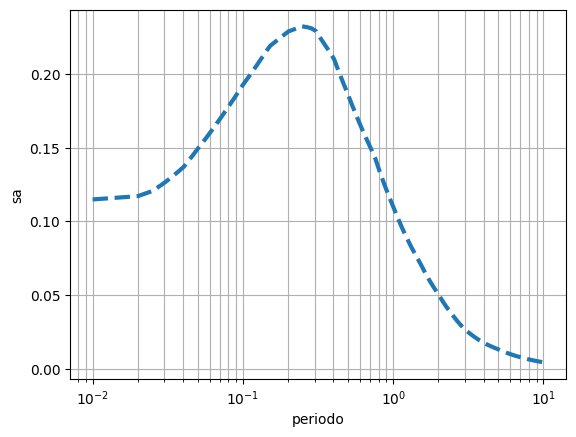

In [52]:
fig,ax=plt.subplots()

ax.set_xscale("log")

ax.plot(periods,results["[ParkerEtAl2020SInter]"]["mean"],lw=3,ls="dashed")

ax.grid(which="both")

ax.set_xlabel("periodo")
ax.set_ylabel("sa")
fig.savefig("espectro.png")